# CAPSTONE_PROJECT_WEEK3

# Explore & Cluster Neighbourhoods in Toronto

### Libraries imported

In [1]:
! pip install --upgrade pip

Requirement already up-to-date: pip in ./common/.virtualenv/python3/lib/python3.5/site-packages (19.0.3)


In [2]:
! pip install beautifulSoup4
print ('done')

done


In [3]:
from bs4 import BeautifulSoup

In [4]:

import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# !conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Libraries imported.


#  1. Extract data of Toronto neighborhoods from Wikipedia

In [5]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

text_result = requests.get(url).text #get the entire html of the article as a str
html_parsed_result = BeautifulSoup(text_result, 'html.parser') #transform the text to html

neighborhood_info_table = html_parsed_result.find('table', class_ = 'wikitable')
neighborhood_rows = neighborhood_info_table.find_all('tr')

# extract the info ('Postcode', 'Borough', 'Neighbourhood') from the table
neighborhood_info = []
for row in neighborhood_rows:
    info = row.text.split('\n')[1:-1] # remove empty str (first and last items)
    neighborhood_info.append(info)
    
neighborhood_info[0:20]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront'],
 ['M5A', 'Downtown Toronto', 'Regent Park'],
 ['M6A', 'North York', 'Lawrence Heights'],
 ['M6A', 'North York', 'Lawrence Manor'],
 ['M7A', "Queen's Park", 'Not assigned'],
 ['M8A', 'Not assigned', 'Not assigned'],
 ['M9A', 'Etobicoke', 'Islington Avenue'],
 ['M1B', 'Scarborough', 'Rouge'],
 ['M1B', 'Scarborough', 'Malvern'],
 ['M2B', 'Not assigned', 'Not assigned'],
 ['M3B', 'North York', 'Don Mills North'],
 ['M4B', 'East York', 'Woodbine Gardens'],
 ['M4B', 'East York', 'Parkview Hill'],
 ['M5B', 'Downtown Toronto', 'Ryerson'],
 ['M5B', 'Downtown Toronto', 'Garden District']]

**transform data into pandas dataframe**

In [6]:
#create a Neighborhoods dataframe
neighborhood_info[0][-1] = 'Neighborhood' # change to american spelling
neighborhood_df = pd.DataFrame(neighborhood_info[1:], columns=neighborhood_info[0])

neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


#  2. Explore and clean neighborhoods dataset¶

In [7]:
not_assigned_boroughs = neighborhood_df.index[neighborhood_df['Borough'] == 'Not assigned']
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned']
not_assigned_neighborhoods_and_borough = not_assigned_boroughs & not_assigned_neighborhoods

print('The DataFrame shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} rows with Not assigned Borough'.format(not_assigned_boroughs.shape[0]))
print('  {} rows with Not assigned Neighborhood'.format(not_assigned_neighborhoods.shape[0]))
print('  {} rows with Not assigned Neighborhood and Borough'.format(not_assigned_neighborhoods_and_borough.shape[0]),'\n')

The DataFrame shape is (288, 3) 

There are:
  180 Postal codes
  11 Boroughs
  208 Neighborhoods
  77 rows with Not assigned Borough
  78 rows with Not assigned Neighborhood
  77 rows with Not assigned Neighborhood and Borough 



# Eliminating "not assigned" values from boroughs

In [8]:
neighborhood_df.drop(neighborhood_df.index[not_assigned_boroughs], inplace=True)
neighborhood_df.reset_index(drop=True, inplace=True)

neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Not assigned
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


### replacing "not assigned values" in neighborhood with borough name

In [9]:
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned'] # run this again because the indexes on the dataframe where reset

for idx in not_assigned_neighborhoods:
    neighborhood_df['Neighborhood'][idx] = neighborhood_df['Borough'][idx]
    
neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Queen's Park
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


In [10]:
print('After cleaning the DataFrame, its new shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0]))
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0]))

After cleaning the DataFrame, its new shape is (211, 3) 

There are:
  103 Postal codes
  11 Boroughs
  209 Neighborhoods


**The dataframe has 103 Postal codes but it has 211 rows, because each Postal code can present more 
than one neighborhood (209 in total).Therefore, the dataframe should be group by the Postal code,
ending with a dataframe with 103 rows.**

In [11]:

group = neighborhood_df.groupby('Postcode')
grouped_neighborhoods = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
grouped_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
grouped_df.columns = ['Postcode', 'Borough', 'Neighborhood']

grouped_df.head(10)

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


**number of rows of your dataframe.**

In [12]:
print('The DataFrame shape is', grouped_df.shape)

The DataFrame shape is (103, 3)


**adding coordinates to postal codes**

In [13]:
coordinates_df = pd.read_csv("Geospatial_Coordinates_capstone_week3.csv") # transform the csv file into a dataframe

print('The coordinates dataframe shape is', coordinates_df.shape)
coordinates_df.head()

The coordinates dataframe shape is (103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


**join coordinates data to above neighborhood data**

In [14]:

postcodes_with_coordinates_df = grouped_df.join(coordinates_df.set_index('Postal Code'), on='Postcode')

postcodes_with_coordinates_df.head(20)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


**Toronto map with postcode positions as blue circles**

In [15]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=12)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=100,
        popup=label,
        location=[location[-2], location[-1]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

**scatter plot for postcode venues in toronto**

In [16]:
! pip install matplotlib

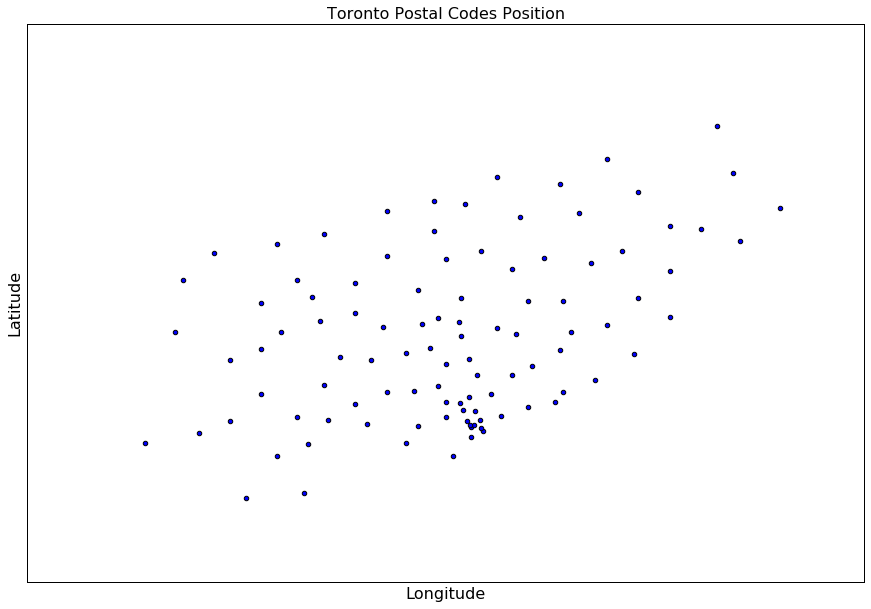

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

X = postcodes_with_coordinates_df[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show();


**To define the radius use with foursquare it's necessary to find the closest points for each postcode**

In [18]:
! pip install geopy

In [19]:

from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

**To explore the distance function, the closest postcode to the first example in the dataframe is found**

In [20]:
coordinates = postcodes_with_coordinates_df[['Latitude', 'Longitude']]

distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-79.194353,43.806686
16,-79.205636,43.836125


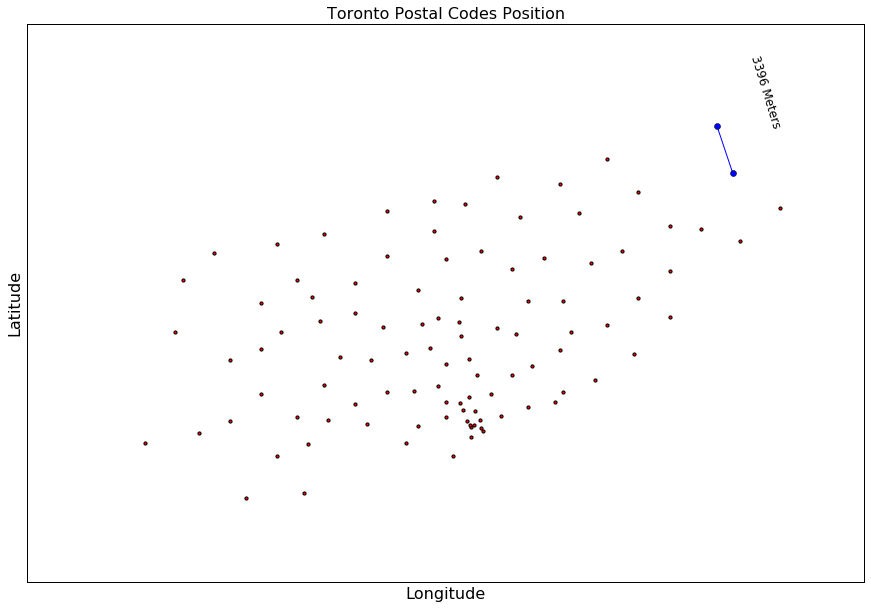

In [21]:
fig = plt.figure(figsize=(15,10))
scatter_plot = fig.add_subplot(111)
scatter_plot.scatter(X['Longitude'],X['Latitude'], s=10, c='r', marker="o")
scatter_plot.plot(close_points['Longitude'], close_points['Latitude'], c='b', marker="o")

# plt.legend(loc='upper left');
scatter_plot.annotate('{} Meters'.format(distance),
            xy=(.859, .912), xycoords='figure fraction',
            ha='left', va='top', rotation=-73,
            fontsize=12)

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)

plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

**A distant column is added to the DataFrame and is used as the radius cover for each postcode**

In [22]:
from math import isnan

for lat, lng, idx in zip(postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    postcodes_with_coordinates_df.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
    
postcodes_with_coordinates_df.head(15)

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1301.0
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1112.0
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1052.0
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,1112.0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1297.0


**The map is plotted using different radius for each postal code. Now not only overlapping was avoided but more area of the city is cover, consequently, more venues are retrieved**

In [23]:

map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-3], location[-2]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=location[-1],
        popup=label,
        location=[location[-3], location[-2]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

In [24]:
not_assigned_boroughs = neighborhood_df.index[neighborhood_df['Borough'] == 'Not assigned']
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned']
not_assigned_neighborhoods_and_borough = not_assigned_boroughs & not_assigned_neighborhoods

print('The DataFrame shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} rows with Not assigned Borough'.format(not_assigned_boroughs.shape[0]))
print('  {} rows with Not assigned Neighborhood'.format(not_assigned_neighborhoods.shape[0]))
print('  {} rows with Not assigned Neighborhood and Borough'.format(not_assigned_neighborhoods_and_borough.shape[0]),'\n')

The DataFrame shape is (211, 3) 

There are:
  103 Postal codes
  10 Boroughs
  208 Neighborhoods
  0 rows with Not assigned Borough
  0 rows with Not assigned Neighborhood
  0 rows with Not assigned Neighborhood and Borough 



**
Next thing to do is explore each Postcode to get venues using the Foursquare API. For that, the credential must be declared**

# get venues

**In order to get the venues in the perimeter of each Postal code, it is necessary to get the geographical coordinates (lat and lng) of each one of those and add them to the dataframe**

In [25]:
CLIENT_ID = '50JJ5W0ZPTP41GMCYUWJRO33GXUHUYBP0XYKR335P2VPNAN1' # your Foursquare ID
CLIENT_SECRET = '03SNEIFDNMFKFHDDYR3NA4VJSJYHCNLAQV2DPK55ENXK0D2W' # your Foursquare Secret
VERSION = '20181102'

**
To explore the data returned by the Foursquare API, a maximum of 100 venues from the first postcode are requested in a radius of 500 meters**

In [26]:

#function to format url
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [27]:
first_postcode = postcodes_with_coordinates_df.iloc[2, :]
url = format_url(first_postcode['Latitude'], first_postcode['Longitude'], first_postcode['Distance'])

url

'https://api.foursquare.com/v2/venues/explore?client_id=50JJ5W0ZPTP41GMCYUWJRO33GXUHUYBP0XYKR335P2VPNAN1&client_secret=03SNEIFDNMFKFHDDYR3NA4VJSJYHCNLAQV2DPK55ENXK0D2W&ll=43.7635726,-79.1887115&v=20181102&radius=1205.0&limit=100'

In [28]:
#function to get batch of venues as a dataframe
def get_venues(url):
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    return json_normalize(venues)

In [29]:
venues_df = get_venues(url)
venues_df.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups
0,0,"[{'type': 'general', 'reasonName': 'globalInte...",e-0-4bc366dab492d13a51b2a860-0,"[{'name': 'Fried Chicken Joint', 'pluralName':...",4bc366dab492d13a51b2a860,4449 Kingston Road,CA,Scarborough,Canada,at Lawrence and Morningside,579,[4449 Kingston Road (at Lawrence and Morningsi...,"[{'lat': 43.76875171771289, 'lng': -79.1879817...",43.768752,-79.187982,M1E 2N7,ON,Chick-N-Joy,0,[]
1,0,"[{'type': 'general', 'reasonName': 'globalInte...",e-0-4ba164fdf964a52039b337e3-1,"[{'name': 'Food & Drink Shop', 'pluralName': '...",4ba164fdf964a52039b337e3,4525 Kingston Rd,CA,West Hill,Canada,Morningside Crossing,933,"[4525 Kingston Rd (Morningside Crossing), West...","[{'lat': 43.77134173380578, 'lng': -79.1843408...",43.771342,-79.184341,NaN,ON,Bulk Barn,0,[]
2,0,"[{'type': 'general', 'reasonName': 'globalInte...",e-0-4b6074e3f964a5200fe729e3-2,"[{'name': 'Pizza Place', 'pluralName': 'Pizza ...",4b6074e3f964a5200fe729e3,4410 Kingston Rd,CA,Scarborough,Canada,NaN,469,"[4410 Kingston Rd, Scarborough ON M1E 2N5, Can...","[{'lat': 43.76769708292701, 'lng': -79.1899135...",43.767697,-79.189914,M1E 2N5,ON,Swiss Chalet Rotisserie & Grill,0,[]
3,0,"[{'type': 'general', 'reasonName': 'globalInte...",e-0-4c9fdb04542b224bca4201a0-3,"[{'name': 'Pizza Place', 'pluralName': 'Pizza ...",4c9fdb04542b224bca4201a0,4218 Lawrence Avenue East,CA,Scarborough,Canada,NaN,701,"[4218 Lawrence Avenue East, Scarborough ON M1E...","[{'lat': 43.76904597684398, 'lng': -79.1843860...",43.769046,-79.184386,M1E 4X9,ON,Little Caesars Pizza,0,[]
4,0,"[{'type': 'general', 'reasonName': 'globalInte...",e-0-4b3a9504f964a520646a25e3-4,"[{'name': 'Liquor Store', 'pluralName': 'Liquo...",4b3a9504f964a520646a25e3,4525 Kingston Rd.,CA,Toronto,Canada,at Lawrence Ave. E,944,"[4525 Kingston Rd. (at Lawrence Ave. E), Toron...","[{'lat': 43.77146181777272, 'lng': -79.1843837...",43.771462,-79.184384,M1E 2P1,ON,LCBO,0,[]


**for us, the relevant information is venue.categories, venue.location.lat, venue.location.lng and venue.name**

In [30]:

#function to clean the venues dataframe
def clean_df(df):
    relevant_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    clean_df = df.loc[:,relevant_columns]

    #rename columns
    clean_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return clean_df 

venues_df = clean_df(venues_df)
venues_df.head()

,Category,Lat,Lng,Name
0,"[{'name': 'Fried Chicken Joint', 'pluralName':...",43.768752,-79.187982,Chick-N-Joy
1,"[{'name': 'Food & Drink Shop', 'pluralName': '...",43.771342,-79.184341,Bulk Barn
2,"[{'name': 'Pizza Place', 'pluralName': 'Pizza ...",43.767697,-79.189914,Swiss Chalet Rotisserie & Grill
3,"[{'name': 'Pizza Place', 'pluralName': 'Pizza ...",43.769046,-79.184386,Little Caesars Pizza
4,"[{'name': 'Liquor Store', 'pluralName': 'Liquo...",43.771462,-79.184384,LCBO


In [31]:
venues_df.loc[0, 'Category']

[{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/friedchicken_',
   'suffix': '.png'},
  'id': '4d4ae6fc7a7b7dea34424761',
  'name': 'Fried Chicken Joint',
  'pluralName': 'Fried Chicken Joints',
  'primary': True,
  'shortName': 'Fried Chicken'}]

**It is necessary to extract the Category (shortName) of the JSON data**

In [32]:
#function that extract the category name
def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

venues_df['Category'] = venues_df.apply(get_category_name, axis=1)

venues_df

,Category,Lat,Lng,Name
0,Fried Chicken Joint,43.768752,-79.187982,Chick-N-Joy
1,Food & Drink Shop,43.771342,-79.184341,Bulk Barn
2,Pizza Place,43.767697,-79.189914,Swiss Chalet Rotisserie & Grill
3,Pizza Place,43.769046,-79.184386,Little Caesars Pizza
4,Liquor Store,43.771462,-79.184384,LCBO
5,Smoothie Shop,43.770668,-79.184150,Booster Juice
6,Breakfast Spot,43.772319,-79.184900,Sunset Grill
7,Coffee Shop,43.770367,-79.186313,Starbucks
8,Beer Store,43.769793,-79.187505,The Beer Store
9,Fast Food Restaurant,43.768347,-79.188368,McDonald's


**Next step is to get venues for each postal code**

In [33]:
#function to construct the dataframe with all the venues (max 100 venues per postal code)
def get_all_venues(postcodes, lat, lng, radius):
    venues_list=[]
    for postcode, lat, lng, radius in zip(postcodes, lat, lng, radius):
        url= format_url(lat, lng, radius)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name'])
            for v in results])
    all_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    all_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                  ]
    
    return all_venues


In [34]:
all_venues = get_all_venues(postcodes_with_coordinates_df['Postcode'], postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df['Distance'])

print('The total number of venues returned is ', all_venues.shape[0])

all_venues.head(10)

The total number of venues returned is  3328


,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
1,M1B,43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
2,M1B,43.806686,-79.194353,Canadiana exhibit,43.817962,-79.193374,Zoo Exhibit
3,M1B,43.806686,-79.194353,Orangutan Exhibit,43.818413,-79.182548,Zoo Exhibit
4,M1B,43.806686,-79.194353,Lion Exhibit,43.819228,-79.186977,Zoo Exhibit
5,M1B,43.806686,-79.194353,penguin exhibit,43.819435,-79.185959,Zoo Exhibit
6,M1B,43.806686,-79.194353,Gorilla Exhibit,43.819080,-79.184235,Zoo Exhibit
7,M1B,43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
8,M1B,43.806686,-79.194353,Harvey's,43.800106,-79.198258,Fast Food Restaurant
9,M1B,43.806686,-79.194353,Staples Morningside,43.800285,-79.196607,Paper / Office Supplies Store


In [35]:
print('Total Toronto postcodes:', postcodes_with_coordinates_df['Postcode'].shape[0])
print('Total Toronto postcodes with venues:', all_venues['Postcode'].unique().shape[0])

Total Toronto postcodes: 103
Total Toronto postcodes with venues: 102


**therefore from above observation, one venue has no postcode**

In [36]:
postcodes_diff = np.setdiff1d(postcodes_with_coordinates_df['Postcode'].values,all_venues['Postcode'].unique())
postcodes_with_coordinates_df[postcodes_with_coordinates_df['Postcode']==postcodes_diff[0]]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance
56,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,111.0


# 4. Analyze venues data

**In order to get a better sense of the best way of clustering the postalcodes, it's necessary to analyze the venues data returned by Foursquare**

In [37]:
venues_in_postcode = all_venues.groupby('Postcode').count()
venues_in_postcode = pd.DataFrame(list(zip(venues_in_postcode.index, venues_in_postcode['Venue'])), 
                                  columns=['Postcode', '# of Venues']).set_index('Postcode').join(postcodes_with_coordinates_df[['Postcode','Distance']].set_index('Postcode'), on='Postcode').reset_index()
venues_in_postcode['Distance'] = np.int64(venues_in_postcode['Distance'])
venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as # of venues

venues_in_postcode.head(10)

,Postcode,# of Venues,Distance
0,M1B,33,1698
1,M1C,9,1625
2,M1E,31,1205
3,M1G,4,913
4,M1H,21,913
5,M1J,26,1301
6,M1K,26,1112
7,M1L,31,1052
8,M1M,18,1112
9,M1N,17,1297


In [38]:
venues_in_postcode[['# of Venues']].describe()

,# of Venues
count,103.000000
mean,32.310680
std,25.364801
min,0.000000
25%,12.500000
50%,26.000000
75%,44.000000
max,100.000000


**The minimum amount of venues present on a postcode is 0, as we add M5E, and the maximum is 100, expected given the limit of venues set on the request sent to the Foursquare API. 50% of the venues presents 26 or less venues.**

**The venues Frequency Distribution of the number of venues is presented next**

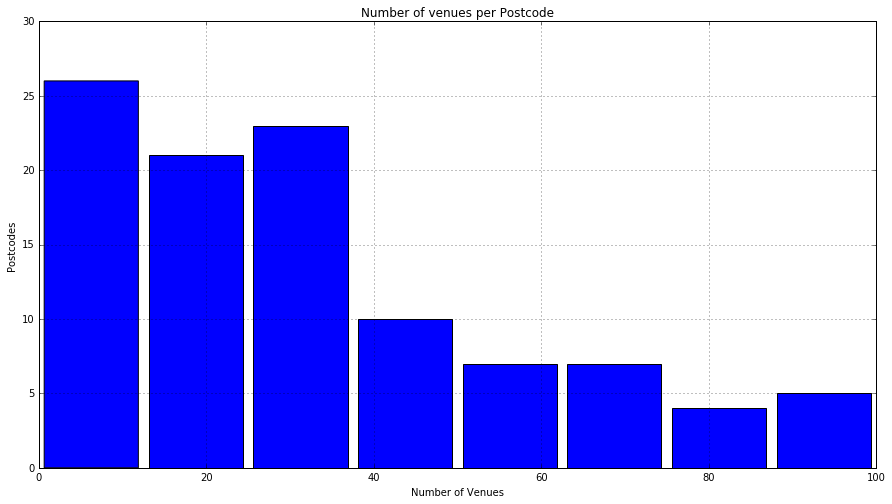

In [39]:
venues_in_postcode['# of Venues'].hist(bins=8, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Postcodes')
plt.title('Number of venues per Postcode')
plt.show()

**Given that each postcode has a different radius passed to the venues request, it's better to represent the venues per postcode in terms of density, that's venues per are cover for each postcode, in this case the area cover in the venues search defined by the distance to the closest postcode.**

In [40]:
density_venues_in_postcode = all_venues.groupby('Postcode').count()

density_venues_in_postcode = pd.DataFrame(list(zip(density_venues_in_postcode.index, density_venues_in_postcode['Venue'])), 
                                  columns=['Postcode', 'Density']).set_index('Postcode').join(postcodes_with_coordinates_df[['Postcode','Distance']].set_index('Postcode'), on='Postcode').reset_index()
density_venues_in_postcode['Density'] = np.int64(density_venues_in_postcode['Density']/(density_venues_in_postcode['Distance']/1000)) #distance in km
density_venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as density

density_venues_in_postcode.head(10)

,Postcode,Density,Distance
0,M1B,19,1698.0
1,M1C,5,1625.0
2,M1E,25,1205.0
3,M1G,4,913.0
4,M1H,23,913.0
5,M1J,19,1301.0
6,M1K,23,1112.0
7,M1L,29,1052.0
8,M1M,16,1112.0
9,M1N,13,1297.0


In [41]:
density_venues_in_postcode[['Density']].describe()

,Density
count,103.000000
mean,46.135922
std,47.953828
min,0.000000
25%,14.500000
50%,29.000000
75%,60.500000
max,257.000000


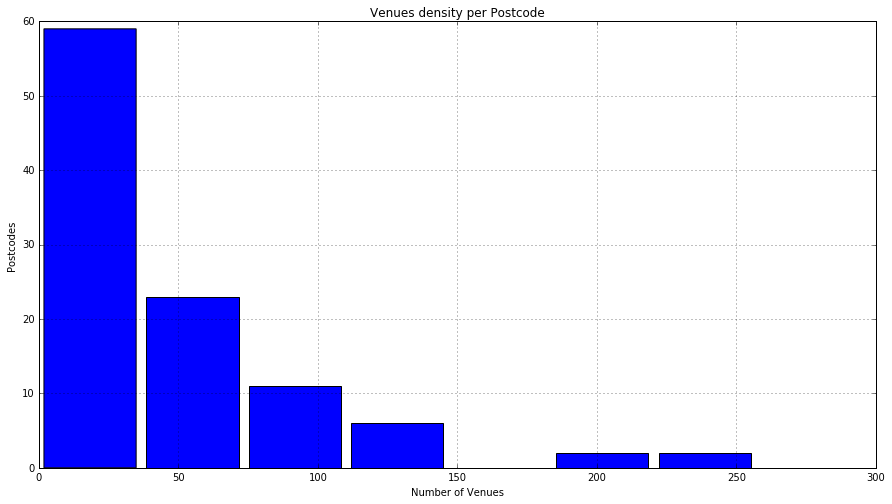

In [42]:

density_venues_in_postcode['Density'].hist(bins=7, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Postcodes')
plt.title('Venues density per Postcode')
plt.show()

**THe histogram shows that 60% of the postcodes presents a density between 0 and 30 venues per area (expressed as radius). That is expected given that Toronto has a low population density. The last three bars on the plot have very low values, it could be possible to merge that data and use 5 venues density ranges for the clustering**

# 5. Cluster Postcodes

**Next the postcodes are clustered based on venues density. One important hyperparameter is the number of clusters and based on previous analysis a tentative value is five clusters. Next the elbow method is used to have a better sense of the optimal number**

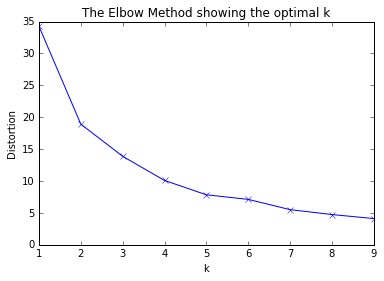

In [43]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(density_venues_in_postcode['Density'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / density_venues_in_postcode['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

**Using the elbow method, the optimal value of the number of cluster was defined as 5, which match with the value based on the histogram analysis**

In [44]:
num_clusters = 5

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[0 0 0 0 0 0 0 4 0 0 4 4 4 4 4 4 0 4 4 0 0 4 2 0 0 4 4 4 4 4 0 0 0 0 0 0 0
 2 2 4 4 3 4 3 0 0 4 2 0 2 0 2 1 2 1 3 2 3 1 2 3 4 0 0 4 2 1 4 2 3 4 4 0 0
 4 4 3 2 0 0 4 2 2 2 0 4 4 4 4 4 0 4 0 0 0 0 0 0 0 0 0 0 0]


In [45]:

density_venues_in_postcode['Cluster'] = k_means.labels_
density_venues_in_postcode.head(10)

,Postcode,Density,Distance,Cluster
0,M1B,19,1698.0,0
1,M1C,5,1625.0,0
2,M1E,25,1205.0,0
3,M1G,4,913.0,0
4,M1H,23,913.0,0
5,M1J,19,1301.0,0
6,M1K,23,1112.0,0
7,M1L,29,1052.0,4
8,M1M,16,1112.0,0
9,M1N,13,1297.0,0


# 6. Examine clusters

**Check the centroids values of venues density and postcodes per cluster**

In [46]:
centroids = np.int64(round(density_venues_in_postcode.groupby('Cluster').mean()['Density']))
frequency = density_venues_in_postcode.groupby('Cluster').count()['Postcode']

cluster_info = pd.DataFrame([np.arange(0,5), centroids, frequency], index=['Cluster', 'Centroid','Postcodes']).T
cluster_info.sort_values('Centroid', inplace=True)
cluster_info.reset_index(drop=True, inplace=True)

cluster_info

,Cluster,Centroid,Postcodes
0,0,13,44
1,4,37,33
2,2,81,15
3,3,123,7
4,1,215,4


In [47]:
**Based on the centroids of each cluster, the cluster names can be defined as:**
    
**'Low Venues Density': Centroid equal to 13**
    
**'Medium-Low Venues Density' with a centroid equal to 37**

**'Medium-High Venues Density' with a centroid equal to 81**

**'High Venues Density' with a centr0id equal to 122**

**'Very High Venues Density' with a centroid equal to 215**

SyntaxError: invalid syntax (<ipython-input-47-f529bdb521a0>, line 1)

In [48]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
clusters=['Low Venues Density','Medium-Low Venues Density','Medium-High Venues Density','High Venues Density','Very High Venues Density']
clusters

['Low Venues Density',
 'Medium-Low Venues Density',
 'Medium-High Venues Density',
 'High Venues Density',
 'Very High Venues Density']

In [50]:
y_values=np.arange(len(clusters))
y_values

array([0, 1, 2, 3, 4])

([<matplotlib.axis.XTick at 0x7fcbacc30668>,
 <a list of 5 Text xticklabel objects>)

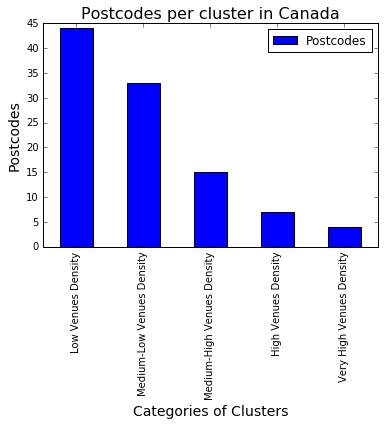

In [55]:
cluster_info.plot(kind='bar',x='Cluster',y='Postcodes', color='b')
plt.title("Postcodes per cluster in Canada", fontsize=16)
plt.xlabel("Categories of Clusters", fontsize=14)
plt.ylabel("Postcodes", fontsize=14)
plt.xticks(y_values, clusters)


### Now above graph shows no. of postcodes against particular category of cluster

**'Low Venues Density': Centroid equal to 13**
    
**'Medium-Low Venues Density' with a centroid equal to 37**

**'Medium-High Venues Density' with a centroid equal to 81**

**'High Venues Density' with a centr0id equal to 122**

**'Very High Venues Density' with a centroid equal to 215**

### now by plotting map of Canada, we will show all neighborhoods with different group of clusters(i.e. venues). If we click on particular circle we will get all information for that location like postcode, borough, neighborhood, category of cluster density
### we will also show different colours and different radius for different categories of clustyer according to their no. of venues present at that location so that anyone can distinguish it fast.
 
**'Low Venues Density' red color**
    
**'Medium-Low Venues Density' green color**

**'Medium-High Venues Density' blue color**

**'High Venues Density' cyan color**

**'Very High Venues Density' magenta color**

### radius of circles will depend on no. of venues present at that location and their distance

In [54]:
postcodes_with_coordinates_df = pd.concat([postcodes_with_coordinates_df[:56],postcodes_with_coordinates_df[57:],postcodes_with_coordinates_df[56:57]]) #move M5E to the last row
postcodes_with_coordinates_df['Cluster'] = k_means.labels_

colors = ['red','green','blue','cyan','magenta']
clusters_values = cluster_info['Cluster']

map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    cluster_index = clusters_values.index[clusters_values==location[-1]][0]
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}; {}'.format(location[1], location[2], location[3], clusters[cluster_index])
    label = folium.Popup(label, parse_html=True)    
    folium.Circle(
        radius=location[-2],
        popup=label,
        location=[location[-4], location[-3]],
        color=None,
        fill=True,
        fill_opacity=0.4,
        fill_color=colors[cluster_index]
    ).add_to(map) 

map

# INSIGHTS

** Business Sense:The results showed on the map could be useful, among others, in Real estate as part of property cost model because venues density could be related to the cost of a property or as a tool for property search.**

** Epidemiology search: venues density could be related with noise, pollution or crime.**

** For Citizens: venues density could be helpful for citizens to hang out.**

** For Immigrants: Venues density would attract more immigrants from different countries or areas to live there.**